In [1]:
import gdown

url = "https://drive.google.com/file/d/1KCKfyIGbQi8a7bIYta3LM8dFStxVzVX-/view?pli=1"

file_id = url.split("/")[-2]
print(file_id)
prefix = 'https://drive.google.com/uc?/export=download&id='
gdown.download(prefix+file_id)
print("Data downloaded!")

1KCKfyIGbQi8a7bIYta3LM8dFStxVzVX-


Downloading...
From (original): https://drive.google.com/uc?/export=download&id=1KCKfyIGbQi8a7bIYta3LM8dFStxVzVX-
From (redirected): https://drive.google.com/uc?%2Fexport=download&id=1KCKfyIGbQi8a7bIYta3LM8dFStxVzVX-&confirm=t&uuid=8dde42d9-411a-4297-83e2-17435250e25a
To: /kaggle/working/Shop DataSet.zip
100%|██████████| 1.78G/1.78G [00:13<00:00, 129MB/s] 

Data downloaded!


In [3]:
import zipfile
import os

# Path to the uploaded zip file
zip_path = '/kaggle/working/Shop DataSet.zip'  # Update this path as per your Drive structure
output_path = '/kaggle/working/data'

# Create the output directory if it doesn't exist
os.makedirs(output_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_path)

print("Data extracted to:", output_path)


Data extracted to: /kaggle/working/data


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import cv2
from tqdm.notebook import tqdm
import random
from PIL import Image
import warnings
import gc  # For explicit garbage collection
warnings.filterwarnings('ignore')

In [5]:
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
set_seed()

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"Available GPU memory: {torch.cuda.memory_reserved(0) / 1e9:.2f} GB")

Using device: cuda
Total GPU memory: 17.06 GB
Available GPU memory: 0.00 GB


In [6]:
DATA_DIR = "/kaggle/working/data/Shop DataSet"  # Change this to your data directory
CLASS_NAMES = ["non shop lifters", "shop lifters"]  # Replace with your actual class names

def extract_frames(video_path, num_frames=8, target_size=(160, 160)):
    """Extract equally spaced frames from a video file with reduced resolution"""
    frames = []
    cap = cv2.VideoCapture(video_path)
    
    # Get total number of frames in the video
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Calculate frame indices to extract (equally spaced)
    frame_indices = np.linspace(0, length-1, num_frames, dtype=np.int32)
    
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            # Resize directly during extraction to save memory
            frame = cv2.resize(frame, target_size)
            # Convert from BGR to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        else:
            # If reading fails, add a blank frame
            frames.append(np.zeros((target_size[0], target_size[1], 3), dtype=np.uint8))
    
    cap.release()
    
    # If we couldn't extract enough frames, pad with blank frames
    while len(frames) < num_frames:
        frames.append(np.zeros((target_size[0], target_size[1], 3), dtype=np.uint8))
        
    return frames

# Create a list of all video files and their labels
def create_video_dataset(data_dir, class_names):
    video_paths = []
    labels = []
    
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith(('.mp4', '.avi', '.mov')):  # Common video extensions
                video_path = os.path.join(class_dir, filename)
                video_paths.append(video_path)
                labels.append(label)
    
    return video_paths, labels

In [7]:
video_paths, labels = create_video_dataset(DATA_DIR, CLASS_NAMES)
print(f"Total videos: {len(video_paths)}")
print(f"Class distribution: {pd.Series(labels).value_counts().to_dict()}")

Total videos: 855
Class distribution: {0: 531, 1: 324}


In [8]:
train_paths, test_paths, train_labels, test_labels = train_test_split(
    video_paths, labels, test_size=0.2, stratify=labels, random_state=42
)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.25, stratify=train_labels, random_state=42
)  # 0.25 * 0.8 = 0.2 of total

print(f"Train videos: {len(train_paths)}")
print(f"Validation videos: {len(val_paths)}")
print(f"Test videos: {len(test_paths)}")


Train videos: 513
Validation videos: 171
Test videos: 171


In [9]:
class VideoDataset(Dataset):
    def __init__(self, video_paths, labels, num_frames=8, transform=None, mode='train'):
        self.video_paths = video_paths
        self.labels = labels
        self.num_frames = num_frames
        self.transform = transform
        self.mode = mode
        
    def __len__(self):
        return len(self.video_paths)
    
    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        frames = extract_frames(video_path, self.num_frames)
        
        # Apply transformations to each frame
        transformed_frames = []
        for frame in frames:
            # Convert numpy array to PIL Image
            frame_pil = Image.fromarray(frame)
            if self.transform:
                frame_pil = self.transform(frame_pil)
            transformed_frames.append(frame_pil)
        
        # Stack frames along a new dimension
        frames_tensor = torch.stack(transformed_frames)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        
        return frames_tensor, label

# Define transformations with reduced image size
train_transform = transforms.Compose([
    transforms.Resize((160, 160)),  # Reduced from 224x224
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((160, 160)),  # Reduced from 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [10]:
NUM_FRAMES = 8  # Reduced from 16
train_dataset = VideoDataset(train_paths, train_labels, num_frames=NUM_FRAMES, transform=train_transform, mode='train')
val_dataset = VideoDataset(val_paths, val_labels, num_frames=NUM_FRAMES, transform=val_transform, mode='val')
test_dataset = VideoDataset(test_paths, test_labels, num_frames=NUM_FRAMES, transform=val_transform, mode='test')

# Create data loaders with smaller batch size
BATCH_SIZE = 4  # Reduced from 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=False)

In [11]:
class LightweightVideoClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(LightweightVideoClassifier, self).__init__()
        
        # Using ResNet18 instead of ResNet50 to reduce memory usage
        base_model = models.resnet18(weights='IMAGENET1K_V1')
        
        # Remove the final fully connected layer
        self.base_model = nn.Sequential(*list(base_model.children())[:-2])
        
        # Feature dimension from ResNet18
        feature_dim = 512  # Reduced from 2048 in ResNet50
        
        # Simplified temporal modeling with a single layer of transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=feature_dim, 
            nhead=4,  # Reduced from 8
            dim_feedforward=1024,  # Reduced from 2048
            dropout=0.1,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)  # Reduced from 2
        
        # Final classification head
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 256),  # Reduced from 512
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        b, t, c, h, w = x.shape  # batch, time, channel, height, width
        
        # Process frames in chunks to save memory
        chunk_size = 4  # Process 4 frames at a time
        features_list = []
        
        for i in range(0, t, chunk_size):
            end = min(i + chunk_size, t)
            chunk = x[:, i:end].contiguous()
            chunk = chunk.view((b * (end - i)), c, h, w)
            
            # Extract features with the CNN base model
            chunk_features = self.base_model(chunk)
            
            # Global average pooling
            chunk_features = nn.functional.adaptive_avg_pool2d(chunk_features, (1, 1))
            chunk_features = chunk_features.view(b, (end - i), -1)
            features_list.append(chunk_features)
            
            # Free up memory
            del chunk, chunk_features
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                
        # Concatenate features
        features = torch.cat(features_list, dim=1)
        
        # Process with transformer
        transformer_out = self.transformer_encoder(features)
        
        # Global temporal pooling (mean across time dimension)
        pooled_features = torch.mean(transformer_out, dim=1)
        
        # Classification
        output = self.classifier(pooled_features)
        
        return output

In [12]:
model = LightweightVideoClassifier(num_classes=len(CLASS_NAMES))
model = model.to(device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 165MB/s]


In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model has {count_parameters(model):,} trainable parameters")

Model has 13,411,138 trainable parameters


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)


In [15]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    # Process in smaller batches
    for frames, labels in tqdm(dataloader, desc="Training"):
        frames, labels = frames.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(frames)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * frames.size(0)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        # Free up memory
        del frames, labels, outputs, loss, preds
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    
    return epoch_loss, epoch_acc, all_preds, all_labels

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for frames, labels in tqdm(dataloader, desc="Validation"):
            frames, labels = frames.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(frames)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * frames.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Free up memory
            del frames, labels, outputs, loss, preds
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    
    return epoch_loss, epoch_acc, all_preds, all_labels

In [16]:
NUM_EPOCHS = 50
best_val_loss = float('inf')
patience = 10  # For early stopping
counter = 0

# Lists to store metrics for plotting
train_losses = []
val_losses = []
train_accs = []
val_accs = []

# Try to free up memory before starting training
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    
    # Train
    train_loss, train_acc, train_preds, train_labels = train_epoch(
        model, train_loader, criterion, optimizer, device
    )
    
    # Validate
    val_loss, val_acc, val_preds, val_labels = validate(
        model, val_loader, criterion, device
    )
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Print statistics
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Confusion matrix for validation
    print("Validation Confusion Matrix:")
    print(confusion_matrix(val_labels, val_preds))
    
    # Store metrics for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'Transformers_video_classifier.pt')
        print("Model saved!")
        counter = 0
    else:
        counter += 1
        
    # Early stopping
    if counter >= patience:
        print(f"Early stopping after {epoch+1} epochs")
        break
        
    # Clear memory at the end of each epoch
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        
    print("-" * 50)

Epoch 1/50


Training:   0%|          | 0/129 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.3592, Train Acc: 0.8480
Val Loss: 0.0370, Val Acc: 0.9942
Validation Confusion Matrix:
[[105   1]
 [  0  65]]
Model saved!
--------------------------------------------------
Epoch 2/50


Training:   0%|          | 0/129 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.2232, Train Acc: 0.9259
Val Loss: 0.0443, Val Acc: 0.9825
Validation Confusion Matrix:
[[103   3]
 [  0  65]]
--------------------------------------------------
Epoch 3/50


Training:   0%|          | 0/129 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.1742, Train Acc: 0.9220
Val Loss: 0.0538, Val Acc: 0.9942
Validation Confusion Matrix:
[[105   1]
 [  0  65]]
--------------------------------------------------
Epoch 4/50


Training:   0%|          | 0/129 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0404, Train Acc: 0.9825
Val Loss: 0.5826, Val Acc: 0.6725
Validation Confusion Matrix:
[[50 56]
 [ 0 65]]
--------------------------------------------------
Epoch 5/50


Training:   0%|          | 0/129 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0984, Train Acc: 0.9669
Val Loss: 0.0130, Val Acc: 0.9942
Validation Confusion Matrix:
[[106   0]
 [  1  64]]
Model saved!
--------------------------------------------------
Epoch 6/50


Training:   0%|          | 0/129 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0665, Train Acc: 0.9825
Val Loss: 0.0390, Val Acc: 0.9883
Validation Confusion Matrix:
[[104   2]
 [  0  65]]
--------------------------------------------------
Epoch 7/50


Training:   0%|          | 0/129 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0366, Train Acc: 0.9864
Val Loss: 0.0068, Val Acc: 1.0000
Validation Confusion Matrix:
[[106   0]
 [  0  65]]
Model saved!
--------------------------------------------------
Epoch 8/50


Training:   0%|          | 0/129 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0017, Train Acc: 1.0000
Val Loss: 0.0025, Val Acc: 1.0000
Validation Confusion Matrix:
[[106   0]
 [  0  65]]
Model saved!
--------------------------------------------------
Epoch 9/50


Training:   0%|          | 0/129 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0047, Train Acc: 0.9981
Val Loss: 0.0059, Val Acc: 1.0000
Validation Confusion Matrix:
[[106   0]
 [  0  65]]
--------------------------------------------------
Epoch 10/50


Training:   0%|          | 0/129 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0524, Train Acc: 0.9864
Val Loss: 0.0182, Val Acc: 0.9942
Validation Confusion Matrix:
[[106   0]
 [  1  64]]
--------------------------------------------------
Epoch 11/50


Training:   0%|          | 0/129 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0296, Train Acc: 0.9903
Val Loss: 0.0020, Val Acc: 1.0000
Validation Confusion Matrix:
[[106   0]
 [  0  65]]
Model saved!
--------------------------------------------------
Epoch 12/50


Training:   0%|          | 0/129 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0769, Train Acc: 0.9786
Val Loss: 0.0028, Val Acc: 1.0000
Validation Confusion Matrix:
[[106   0]
 [  0  65]]
--------------------------------------------------
Epoch 13/50


Training:   0%|          | 0/129 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0027, Train Acc: 1.0000
Val Loss: 0.0008, Val Acc: 1.0000
Validation Confusion Matrix:
[[106   0]
 [  0  65]]
Model saved!
--------------------------------------------------
Epoch 14/50


Training:   0%|          | 0/129 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0100, Train Acc: 0.9961
Val Loss: 0.0007, Val Acc: 1.0000
Validation Confusion Matrix:
[[106   0]
 [  0  65]]
Model saved!
--------------------------------------------------
Epoch 15/50


Training:   0%|          | 0/129 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0182, Train Acc: 0.9961
Val Loss: 0.0014, Val Acc: 1.0000
Validation Confusion Matrix:
[[106   0]
 [  0  65]]
--------------------------------------------------
Epoch 16/50


Training:   0%|          | 0/129 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0016, Train Acc: 1.0000
Val Loss: 0.0008, Val Acc: 1.0000
Validation Confusion Matrix:
[[106   0]
 [  0  65]]
--------------------------------------------------
Epoch 17/50


Training:   0%|          | 0/129 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0006, Train Acc: 1.0000
Val Loss: 0.0006, Val Acc: 1.0000
Validation Confusion Matrix:
[[106   0]
 [  0  65]]
Model saved!
--------------------------------------------------
Epoch 18/50


Training:   0%|          | 0/129 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0006, Train Acc: 1.0000
Val Loss: 0.0217, Val Acc: 0.9942
Validation Confusion Matrix:
[[105   1]
 [  0  65]]
--------------------------------------------------
Epoch 19/50


Training:   0%|          | 0/129 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0817, Train Acc: 0.9864
Val Loss: 0.0090, Val Acc: 1.0000
Validation Confusion Matrix:
[[106   0]
 [  0  65]]
--------------------------------------------------
Epoch 20/50


Training:   0%|          | 0/129 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0016, Train Acc: 1.0000
Val Loss: 0.0007, Val Acc: 1.0000
Validation Confusion Matrix:
[[106   0]
 [  0  65]]
--------------------------------------------------
Epoch 21/50


Training:   0%|          | 0/129 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0008, Train Acc: 1.0000
Val Loss: 0.0006, Val Acc: 1.0000
Validation Confusion Matrix:
[[106   0]
 [  0  65]]
--------------------------------------------------
Epoch 22/50


Training:   0%|          | 0/129 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0007, Train Acc: 1.0000
Val Loss: 0.0003, Val Acc: 1.0000
Validation Confusion Matrix:
[[106   0]
 [  0  65]]
Model saved!
--------------------------------------------------
Epoch 23/50


Training:   0%|          | 0/129 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0179, Train Acc: 0.9961
Val Loss: 0.0004, Val Acc: 1.0000
Validation Confusion Matrix:
[[106   0]
 [  0  65]]
--------------------------------------------------
Epoch 24/50


Training:   0%|          | 0/129 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0628, Train Acc: 0.9844
Val Loss: 0.7427, Val Acc: 0.8596
Validation Confusion Matrix:
[[82 24]
 [ 0 65]]
--------------------------------------------------
Epoch 25/50


Training:   0%|          | 0/129 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.1057, Train Acc: 0.9708
Val Loss: 0.0135, Val Acc: 1.0000
Validation Confusion Matrix:
[[106   0]
 [  0  65]]
--------------------------------------------------
Epoch 26/50


Training:   0%|          | 0/129 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0981, Train Acc: 0.9747
Val Loss: 0.0076, Val Acc: 1.0000
Validation Confusion Matrix:
[[106   0]
 [  0  65]]
--------------------------------------------------
Epoch 27/50


Training:   0%|          | 0/129 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0018, Train Acc: 1.0000
Val Loss: 0.0013, Val Acc: 1.0000
Validation Confusion Matrix:
[[106   0]
 [  0  65]]
--------------------------------------------------
Epoch 28/50


Training:   0%|          | 0/129 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0032, Train Acc: 0.9981
Val Loss: 0.0010, Val Acc: 1.0000
Validation Confusion Matrix:
[[106   0]
 [  0  65]]
--------------------------------------------------
Epoch 29/50


Training:   0%|          | 0/129 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0151, Train Acc: 0.9942
Val Loss: 0.0160, Val Acc: 0.9942
Validation Confusion Matrix:
[[105   1]
 [  0  65]]
--------------------------------------------------
Epoch 30/50


Training:   0%|          | 0/129 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0233, Train Acc: 0.9922
Val Loss: 0.0547, Val Acc: 0.9942
Validation Confusion Matrix:
[[105   1]
 [  0  65]]
--------------------------------------------------
Epoch 31/50


Training:   0%|          | 0/129 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0125, Train Acc: 0.9981
Val Loss: 0.0599, Val Acc: 0.9708
Validation Confusion Matrix:
[[105   1]
 [  4  61]]
--------------------------------------------------
Epoch 32/50


Training:   0%|          | 0/129 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Train Loss: 0.0113, Train Acc: 0.9981
Val Loss: 0.0738, Val Acc: 0.9649
Validation Confusion Matrix:
[[106   0]
 [  6  59]]
Early stopping after 32 epochs


In [18]:
torch.save(model, 'Theft Detection For Shops Model.pth')

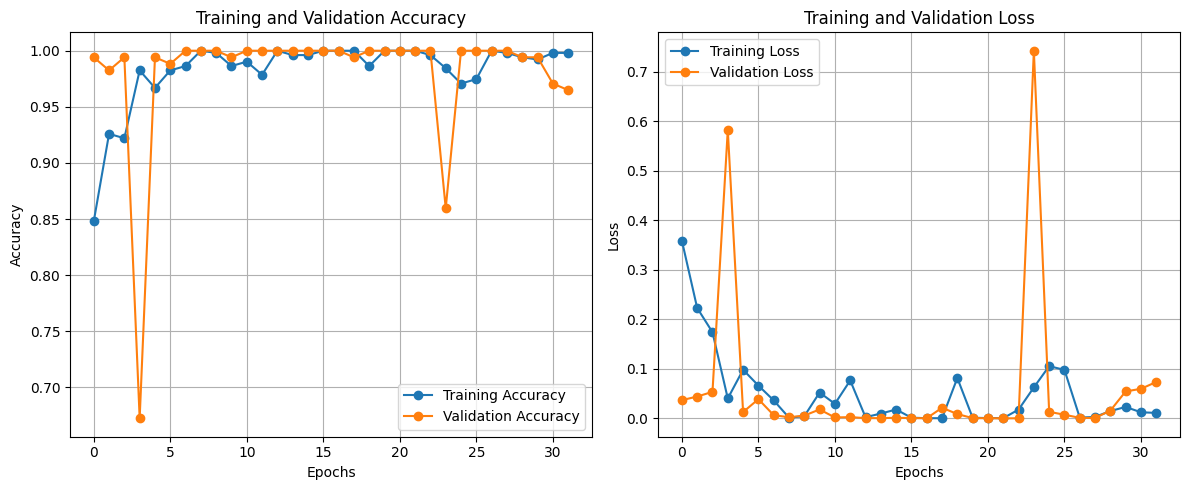

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot Accuracy
ax[0].plot(train_accs, label='Training Accuracy', marker='o')
ax[0].plot(val_accs, label='Validation Accuracy', marker='o')
ax[0].set_title('Training and Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)

# Plot Loss
ax[1].plot(train_losses, label='Training Loss', marker='o')
ax[1].plot(val_losses, label='Validation Loss', marker='o')
ax[1].set_title('Training and Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

In [20]:
model.load_state_dict(torch.load('Transformers_video_classifier.pt'))

# Evaluate on test set
test_loss, test_acc, test_preds, test_labels = validate(
    model, test_loader, criterion, device
)

print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

# Print confusion matrix and classification report
print("Test Confusion Matrix:")
cm = confusion_matrix(test_labels, test_preds)
print(cm)

print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=CLASS_NAMES))

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Test Loss: 0.0003, Test Acc: 1.0000
Test Confusion Matrix:
[[106   0]
 [  0  65]]

Classification Report:
                  precision    recall  f1-score   support

non shop lifters       1.00      1.00      1.00       106
    shop lifters       1.00      1.00      1.00        65

        accuracy                           1.00       171
       macro avg       1.00      1.00      1.00       171
    weighted avg       1.00      1.00      1.00       171



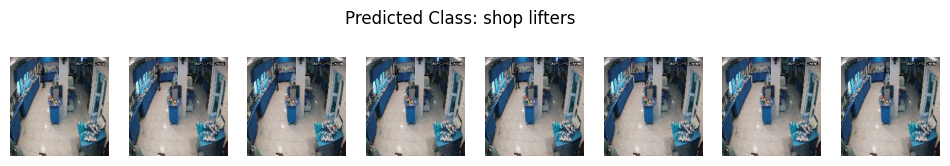

Predicted class: shop lifters
Prediction probabilities: [4.2602568e-04 9.9957401e-01]


In [21]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torch
import numpy as np

def visualize_video(video_path, model, transform, num_frames=8, device='cuda'):
    """
    Visualize video frames with predicted class
    """
    model.eval()
    
    # Extract frames from the video
    frames = extract_frames(video_path, num_frames)
    transformed_frames = []

    for frame in frames:
        frame_pil = Image.fromarray(frame)
        transformed_frames.append(transform(frame_pil))

    # Stack frames and add batch dimension
    frames_tensor = torch.stack(transformed_frames).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        outputs = model(frames_tensor)
        _, preds = torch.max(outputs, 1)
        probabilities = torch.softmax(outputs, dim=1).cpu().numpy()[0]

    # Visualize frames and predicted class
    plt.figure(figsize=(12, 2))
    for idx, frame in enumerate(frames):
        plt.subplot(1, num_frames, idx + 1)
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')

    plt.suptitle(f"Predicted Class: {CLASS_NAMES[preds.item()]}")
    plt.show()

    # Free up memory
    del frames_tensor, outputs
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return preds.item(), probabilities

# Example usage
sample_video = "/kaggle/working/data/Shop DataSet/shop lifters/shop_lifter_104.mp4"
pred_class, pred_probs = visualize_video(sample_video, model, val_transform, device=device)
print(f"Predicted class: {CLASS_NAMES[pred_class]}")
print(f"Prediction probabilities: {pred_probs}")